In [1]:
from sklearn.datasets import load_svmlight_file
from sklearn.cross_validation import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

/home/w2w/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# 读取数据
data = load_svmlight_file(f='a9a')

In [3]:
# 分割数据
x_train, x_test, y_train, y_test = train_test_split(data[0], data[1], test_size=0.4, random_state=0)

In [4]:
x_train.shape

(19536, 123)

In [5]:
class Logistic(object):
    '''
    Parameters:
    ----------
        turns_ : max iteration numbers
        learning_rate_ : learning rate
        silence_ : print process or not
        plot_ : plot or not
        
    Attribute:
    ----------
        w_ : array, shape (n_features, ), [w1, w2, ..., wn]
        b_ : w0, bias
        
    Data format:
    ----------
        y : m*1
        x : m*n
        w : n*1
        b : 1*1 
    '''
    def __init__(self, turns = 50, c=0.1, learning_rate = 0.01, batch_size = 0.05, 
                 silence = False, plot = True, method='AdaDelta'):
        self.turns_ = turns
        self.learning_rate_ = learning_rate
        self.silence_ = silence
        self.plot_ = plot
        self.method_ =  method
        self.c_ = c
        self.batch_size_ = 0.05
        
    def calc_error(self, X, y, w, b):
        '''
            error = 1/N* ln(1+e^(-yn*(wT*xn+b))
        '''
        N = X.shape[0]
        t1 = X.dot(w)
        t = -y*(X.dot(w)+b)
        error = 1.0/N*np.sum(np.log(1+np.exp(-y*(X.dot(w)+b))))
        return error
    
    def calc_gradient(self, X, y, w, b):
        '''
            计算梯度
            g_w = -1.0/N*y*X / (1+np.exp(y*(X.dot(w)+b)))
        '''
        N = X.shape[0]
        temp = -1.0/N*y/(1+np.exp(y*(X.dot(w)+b)))
        g_w = np.zeros(X.shape[1])
        for i in range(N):
            g_w += (X[i] * temp[i]).toarray()[0]
        g_b = np.sum(-1.0/N*y/(1+np.exp(y*(X.dot(w)+b))))
        return g_w, g_b
    
    def gradient(self, X, y, w, b, method='AdaDelta'):
        if method == 'AdaDelta':
            return self.AdaDelta(X, y, w, b)
        elif method == 'Adam':
            return self.Adam(X, y, w, b)
        elif method == 'NAG':
            return self.NAG(X, y, w, b)
        elif method == 'RMSProp':
            return self.RMSProp(X, y, w, b)
        else:
            print("No this method")
    
    def AdaDelta(self, X, y, w, b):
        '''
            y_ = Xw + b
            delta = gamma*delta + (1-gamma)*g_t.dot(g_t)
            g_w = (2/N)*XT*(y_-y)
            G_w_t = G_w_t + g^2
            g_b = (2/N)*(y_-y)
            G_b_t = G_b_t + g^2
        '''
        if hasattr(self, 'G_w_t') == False:
            self.G_w_t = 0
            self.G_b_t = 0
            self.delta_w = 0
            self.delta_b = 0
        N = X.shape[0]
        y_ = X.dot(w) + b
        # 求梯度
#         g_w = (2/float(N))*X.T*(y_ - y)
#         g_b = (2/float(N))*np.sum(y_-y)
        g_w, g_b = self.calc_gradient(X, y, w, b)
        gamma = 0.95
        # 求Gt
        self.G_w_t = gamma*self.G_w_t + (1-gamma)*g_w.dot(g_w)
        self.G_b_t = gamma*self.G_b_t + (1-gamma)*g_b*g_b
        # 求delta_theta
        d_w = -((self.delta_w + 10**(-8))**0.5)/((self.G_w_t + 10**(-8))**0.5)*g_w
#         d_w1 = - self.learning_rate_/((self.G_w_t + 10**(-8))**0.5)*g_w
        d_b = -((self.delta_b + 10**(-8))**0.5)/((self.G_b_t + 10**(-8))**0.5)*g_b
        # 求delta_t
        self.delta_w = gamma*self.delta_w + (1-gamma)*d_w.dot(d_w)
        self.delta_b = gamma*self.delta_b + (1-gamma)*d_b*d_b
        w1 = w + d_w
        b1 = b + d_b
        return w1, b1
    
    def Adam(self, X, y, w, b):
        '''
            y_ = Xw + b
            g_w = (2/N)*XT*(y_-y)
            G_w_t = G_w_t + g^2
            g_b = (2/N)*(y_-y)
            G_b_t = G_b_t + g^2
        '''
        if hasattr(self, 'm_w_t') == False:
            n_features = X.shape[1]
            self.m_w_t = np.zeros([n_features])
            self.m_b_t = 0
            self.G_w_t = 0
            self.G_b_t = 0
            self.t = 0
        self.t += 1
        g_w, g_b = self.calc_gradient(X, y, w, b)
        belta = 0.9
        gamma = 0.9
        # 求 m_t
        self.m_w_t = belta*self.m_w_t + (1-belta)*g_w
        self.m_b_t = belta*self.m_b_t + (1-belta)*g_b
        # 求 G_t
        self.G_w_t = gamma*self.G_w_t + (1-gamma)*g_w.dot(g_w)
        self.G_b_t = gamma*self.G_b_t + (1-gamma)*g_b*g_b
        a = self.learning_rate_*(1-gamma**self.t)**0.5/(1-belta**self.t)
        w1 = w - a*self.m_w_t/((self.G_w_t + 10**(-8))**0.5)
        b1 = b - a*self.m_b_t/((self.G_b_t + 10**(-8))**0.5)
        
        return w1, b1
    
    def NAG(self, X, y, w, b):
        '''
            y_ = Xw + b
            g_w = (2/N)*XT*(y_-y)
            G_w_t = G_w_t + g^2
            g_b = (2/N)*(y_-y)
            G_b_t = G_b_t + g^2
        '''
        if hasattr(self, 'v_w_t') == False:
            n_features = X.shape[1]
            self.v_w_t = np.zeros([n_features])
            self.v_b_t = 0
        g_w, g_b = self.calc_gradient(X, y, w, b)
        gamma = 0.9
        self.v_w_t = gamma*self.v_w_t + self.learning_rate_*g_w
        self.v_b_t = gamma*self.v_b_t + self.learning_rate_*g_b
        w1 = w - self.v_w_t
        b1 = b - self.v_b_t
        return w1, b1
    
    def RMSProp(self, X, y, w, b):
        '''
            y_ = Xw + b
            
            g_w = (2/N)*XT*(y_-y)
            G_w_t = G_w_t + g^2
            g_b = (2/N)*(y_-y)
            G_b_t = G_b_t + g^2
        '''
        if hasattr(self, 'G_w_t') == False:
            self.G_w_t = 0
            self.G_b_t = 0
        g_w, g_b = self.calc_gradient(X, y, w, b)
        gamma = 0.9
        self.G_w_t = gamma*self.G_w_t + (1-gamma)*g_w.dot(g_w)
        self.G_b_t = gamma*self.G_b_t + (1-gamma)*g_b*g_b
#         print("G_w_t:", self.G_w_t)
#         print("G_b_t:", self.G_b_t)
        w1 = w - self.learning_rate_/((self.G_w_t + 10**(-8))**0.5)*g_w
        b1 = b - self.learning_rate_/((self.G_b_t + 10**(-8))**0.5)*g_b
        return w1, b1
    
    def fit(self, X_train, y_train, X_test, y_test):
        '''
            Minibatch Stochastic Gradient descent
        '''
        n_features = X_train.shape[1]
        n_targets = 1
        self.w_ = np.zeros([n_features])
        self.b_ = 0
        train_loss_list = []
        test_loss_list = []
        batch_size = int(self.batch_size_*X_train.shape[0])
        for i in range(self.turns_):
            if self.silence_ == False:
                print('Turn %d'%i)
                print('w:', self.w_)
                print('b:', self.b_)
                print('Train Loss:', self.calc_error(X_train, y_train, self.w_, self.b_))
                print('Test Loss:', self.calc_error(X_test, y_test, self.w_, self.b_))
                print('---------------------------')
            index = random.sample(range(X_train.shape[0]), batch_size)
            train_loss_list.append(self.calc_error(X_train, y_train, self.w_, self.b_))
            test_loss_list.append(self.calc_error(X_test, y_test, self.w_, self.b_))
            batch_X_train = X_train[index]
            batch_y_train = y_train[index]
            self.w_, self.b_ = self.gradient(batch_X_train, batch_y_train, self.w_, self.b_, method=self.method_)
        print('Iteration End')
        if self.silence_ == False:
            print('w:', self.w_)
            print('b:', self.b_)
        print('Train Loss:', self.calc_error(X_train, y_train, self.w_, self.b_))
        print('Test Loss:', self.calc_error(X_test, y_test, self.w_, self.b_))
        print('---------------------------')
        if self.plot_ == True:
            fig1, = plt.plot(range(self.turns_), train_loss_list)
            fig2, = plt.plot(range(self.turns_), test_loss_list)
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.legend(handles=[fig1,fig2], labels=['train_loss','validate_loss'], loc='best')
            plt.title(self.method_)
            plt.show()
        self.train_loss_list = train_loss_list
        self.test_loss_list = test_loss_list

Iteration End
Train Loss: 0.436722913661
Test Loss: 0.437545161838
---------------------------


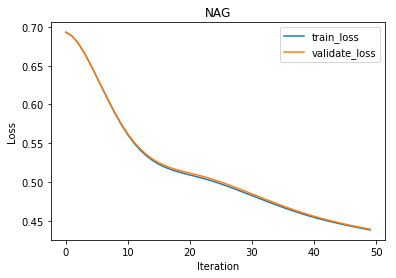

In [6]:
clf1 = Logistic(turns = 50, learning_rate = 0.01, c=0.01, silence=True, method='NAG')
clf1.fit(x_train, y_train, x_test, y_test)

Iteration End
Train Loss: 0.489360172017
Test Loss: 0.491001159082
---------------------------


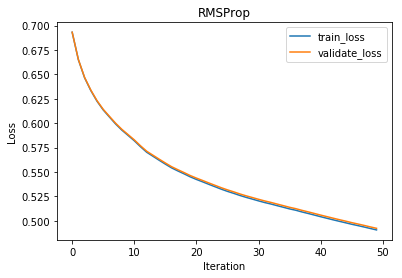

In [7]:
clf2 = Logistic(turns = 50, learning_rate = 0.01, silence=True, c=0.01, method='RMSProp')
clf2.fit(x_train, y_train, x_test, y_test)

Iteration End
Train Loss: 0.672815612359
Test Loss: 0.672968572213
---------------------------


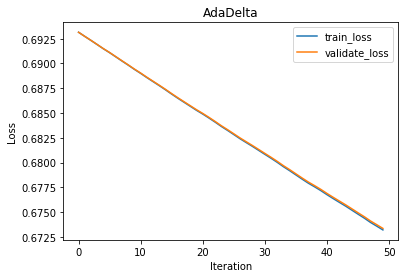

In [8]:
clf3 = Logistic(turns = 50, silence=True, c=0.01, method='AdaDelta')
clf3.fit(x_train, y_train, x_test, y_test)

Iteration End
Train Loss: 0.499993466731
Test Loss: 0.502093729467
---------------------------


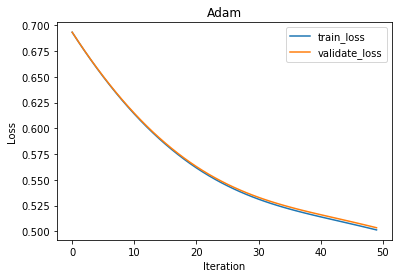

In [9]:
clf4 = Logistic(turns = 50, learning_rate = 0.01, c=0.01, silence=True, method='Adam')
clf4.fit(x_train, y_train, x_test, y_test)

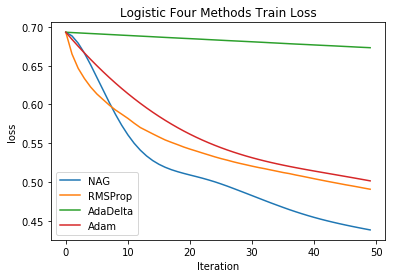

In [10]:
# plot all train_loss
fig1, = plt.plot(range(50), clf1.train_loss_list)
fig2, = plt.plot(range(50), clf2.train_loss_list)
fig3, = plt.plot(range(50), clf3.train_loss_list)
fig4, = plt.plot(range(50), clf4.train_loss_list)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.legend(handles=[fig1,fig2, fig3, fig4], labels=['NAG','RMSProp', 'AdaDelta', 'Adam'], loc='best')
plt.title("Logistic Four Methods Train Loss")
plt.show()

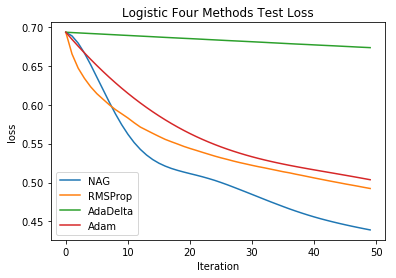

In [11]:
# plot all test_loss
fig1, = plt.plot(range(50), clf1.test_loss_list)
fig2, = plt.plot(range(50), clf2.test_loss_list)
fig3, = plt.plot(range(50), clf3.test_loss_list)
fig4, = plt.plot(range(50), clf4.test_loss_list)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.legend(handles=[fig1,fig2, fig3, fig4], labels=['NAG','RMSProp', 'AdaDelta', 'Adam'], loc='best')
plt.title("Logistic Four Methods Test Loss")
plt.show()